# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [8]:
student1 = "Pau Argelaguet Franquelo"
student2 = "Natalie Bolon Brun"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [10]:
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam

from keras.models import Sequential
from keras.layers import Dense, Activation

# you may experiment with different subsets, 
# but make sure in the submission 
# it is generated with the correct random seed for all exercises.
np.random.seed(hash(student1 + student2) % 2**32)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

### Plotting

In [11]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [12]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)


data_train = scipy.io.loadmat('data/train_32x32.mat')
data_test = scipy.io.loadmat('data/test_32x32.mat')

x_train_all, y_train_all = preprocess(data_train)
x_test_all, y_test_all = preprocess(data_test)

### Selecting a subset of classes

We furter reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [13]:
def extract_classes(x, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x[indices], labels

x_train, y_train = extract_classes(x_train_all, y_train_all, subset_of_classes)
x_test, y_test = extract_classes(x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

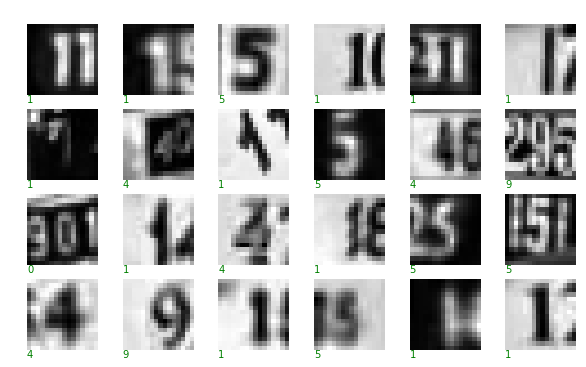

In [14]:
plot_some_samples(x_test, y_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [15]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

In [ ]:
model = Sequential([
    Dense(32, input_shape=(256,)),
    Activation('relu'),
    Dense(5),
    Activation('softmax'),
])

model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=1000, validation_split=0.2, batch_size=128, verbose=1)

Train on 30246 samples, validate on 7562 samples
Epoch 1/1000
30246/30246 [==============================] - 1s 23us/step - loss: 1.6134 - acc: 0.2293 - val_loss: 1.5770 - val_acc: 0.1010
Epoch 2/1000
30246/30246 [==============================] - 0s 15us/step - loss: 1.5897 - acc: 0.2643 - val_loss: 1.5685 - val_acc: 0.0803
Epoch 3/1000
30246/30246 [==============================] - 1s 37us/step - loss: 1.5822 - acc: 0.2786 - val_loss: 1.5574 - val_acc: 0.1037
Epoch 4/1000
30246/30246 [==============================] - 1s 30us/step - loss: 1.5751 - acc: 0.2925 - val_loss: 1.5577 - val_acc: 0.1083
Epoch 5/1000
30246/30246 [==============================] - 0s 16us/step - loss: 1.5682 - acc: 0.3038 - val_loss: 1.5421 - val_acc: 0.1139
Epoch 6/1000
30246/30246 [==============================] - 0s 15us/step - loss: 1.5611 - acc: 0.3099 - val_loss: 1.5116 - val_acc: 0.1953
Epoch 7/1000
30246/30246 [==============================] - 0s 16us/step - loss: 1.5539 - acc: 0.3208 - val_loss: 1.5

Epoch 59/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.9465 - acc: 0.7049 - val_loss: 0.8400 - val_acc: 0.7982
Epoch 60/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.9384 - acc: 0.7086 - val_loss: 0.8269 - val_acc: 0.8102
Epoch 61/1000
30246/30246 [==============================] - 1s 17us/step - loss: 0.9306 - acc: 0.7123 - val_loss: 0.8461 - val_acc: 0.7936
Epoch 62/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.9232 - acc: 0.7147 - val_loss: 0.8632 - val_acc: 0.7862
Epoch 63/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.9156 - acc: 0.7182 - val_loss: 0.8318 - val_acc: 0.7958
Epoch 64/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.9089 - acc: 0.7198 - val_loss: 0.8596 - val_acc: 0.7854
Epoch 65/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.9022 - acc: 0.7241 - val_loss: 0.8284 - val_acc: 0.7974
Epoch 66/1000
30246/

30246/30246 [==============================] - 0s 16us/step - loss: 0.7258 - acc: 0.7831 - val_loss: 0.7060 - val_acc: 0.8211
Epoch 118/1000
30246/30246 [==============================] - 1s 21us/step - loss: 0.7240 - acc: 0.7836 - val_loss: 0.6730 - val_acc: 0.8335
Epoch 119/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.7224 - acc: 0.7840 - val_loss: 0.7290 - val_acc: 0.8094
Epoch 120/1000
30246/30246 [==============================] - 1s 23us/step - loss: 0.7205 - acc: 0.7847 - val_loss: 0.6340 - val_acc: 0.8471
Epoch 121/1000
30246/30246 [==============================] - 1s 21us/step - loss: 0.7187 - acc: 0.7852 - val_loss: 0.6799 - val_acc: 0.8265
Epoch 122/1000
30246/30246 [==============================] - 1s 20us/step - loss: 0.7172 - acc: 0.7863 - val_loss: 0.6976 - val_acc: 0.8223
Epoch 123/1000
30246/30246 [==============================] - 2s 53us/step - loss: 0.7158 - acc: 0.7863 - val_loss: 0.7010 - val_acc: 0.8213
Epoch 124/1000
30246/30246 [

30246/30246 [==============================] - 0s 16us/step - loss: 0.6568 - acc: 0.8052 - val_loss: 0.6246 - val_acc: 0.8414
Epoch 176/1000
30246/30246 [==============================] - 1s 28us/step - loss: 0.6558 - acc: 0.8049 - val_loss: 0.6489 - val_acc: 0.8343
Epoch 177/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.6550 - acc: 0.8052 - val_loss: 0.6217 - val_acc: 0.8432
Epoch 178/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.6539 - acc: 0.8062 - val_loss: 0.6202 - val_acc: 0.8441
Epoch 179/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.6532 - acc: 0.8064 - val_loss: 0.6618 - val_acc: 0.8256
Epoch 180/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.6520 - acc: 0.8065 - val_loss: 0.6157 - val_acc: 0.8453
Epoch 181/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.6512 - acc: 0.8069 - val_loss: 0.6563 - val_acc: 0.8290
Epoch 182/1000
30246/30246 [

30246/30246 [==============================] - 1s 40us/step - loss: 0.6073 - acc: 0.8209 - val_loss: 0.5864 - val_acc: 0.8544
Epoch 234/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.6063 - acc: 0.8213 - val_loss: 0.6203 - val_acc: 0.8422
Epoch 235/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.6056 - acc: 0.8212 - val_loss: 0.6108 - val_acc: 0.8440
Epoch 236/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.6048 - acc: 0.8215 - val_loss: 0.6103 - val_acc: 0.8445
Epoch 237/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.6040 - acc: 0.8223 - val_loss: 0.5740 - val_acc: 0.8580
Epoch 238/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.6029 - acc: 0.8226 - val_loss: 0.6122 - val_acc: 0.8463
Epoch 239/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.6026 - acc: 0.8223 - val_loss: 0.5908 - val_acc: 0.8516
Epoch 240/1000
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.5611 - acc: 0.8360 - val_loss: 0.5654 - val_acc: 0.8581
Epoch 292/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.5605 - acc: 0.8365 - val_loss: 0.5358 - val_acc: 0.8701
Epoch 293/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.5592 - acc: 0.8366 - val_loss: 0.5709 - val_acc: 0.8570
Epoch 294/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.5586 - acc: 0.8370 - val_loss: 0.5665 - val_acc: 0.8582
Epoch 295/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.5581 - acc: 0.8374 - val_loss: 0.5771 - val_acc: 0.8549
Epoch 296/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.5574 - acc: 0.8370 - val_loss: 0.5192 - val_acc: 0.8765
Epoch 297/1000
30246/30246 [==============================] - 1s 43us/step - loss: 0.5563 - acc: 0.8374 - val_loss: 0.5833 - val_acc: 0.8508
Epoch 298/1000
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.5229 - acc: 0.8479 - val_loss: 0.5020 - val_acc: 0.8791
Epoch 350/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.5221 - acc: 0.8482 - val_loss: 0.5096 - val_acc: 0.8787
Epoch 351/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.5217 - acc: 0.8485 - val_loss: 0.5165 - val_acc: 0.8764
Epoch 352/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.5207 - acc: 0.8492 - val_loss: 0.5192 - val_acc: 0.8716
Epoch 353/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.5203 - acc: 0.8498 - val_loss: 0.5310 - val_acc: 0.8732
Epoch 354/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.5195 - acc: 0.8500 - val_loss: 0.5741 - val_acc: 0.8584
Epoch 355/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.5189 - acc: 0.8494 - val_loss: 0.5784 - val_acc: 0.8559
Epoch 356/1000
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.4892 - acc: 0.8602 - val_loss: 0.5244 - val_acc: 0.8690
Epoch 408/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.4890 - acc: 0.8607 - val_loss: 0.4859 - val_acc: 0.8868
Epoch 409/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4882 - acc: 0.8598 - val_loss: 0.5430 - val_acc: 0.8655
Epoch 410/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4884 - acc: 0.8597 - val_loss: 0.5422 - val_acc: 0.8682
Epoch 411/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4876 - acc: 0.8600 - val_loss: 0.4899 - val_acc: 0.8840
Epoch 412/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4871 - acc: 0.8602 - val_loss: 0.4709 - val_acc: 0.8884
Epoch 413/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4866 - acc: 0.8606 - val_loss: 0.5150 - val_acc: 0.8740
Epoch 414/1000
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.4629 - acc: 0.8672 - val_loss: 0.5028 - val_acc: 0.8775
Epoch 466/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.4625 - acc: 0.8677 - val_loss: 0.4785 - val_acc: 0.8853
Epoch 467/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4620 - acc: 0.8680 - val_loss: 0.4909 - val_acc: 0.8818
Epoch 468/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4618 - acc: 0.8673 - val_loss: 0.4990 - val_acc: 0.8799
Epoch 469/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4614 - acc: 0.8679 - val_loss: 0.5265 - val_acc: 0.8711
Epoch 470/1000
30246/30246 [==============================] - 1s 22us/step - loss: 0.4610 - acc: 0.8675 - val_loss: 0.5070 - val_acc: 0.8750
Epoch 471/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4607 - acc: 0.8677 - val_loss: 0.5089 - val_acc: 0.8720
Epoch 472/1000
30246/30246 [

30246/30246 [==============================] - 0s 16us/step - loss: 0.4424 - acc: 0.8732 - val_loss: 0.4590 - val_acc: 0.8929
Epoch 524/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4421 - acc: 0.8722 - val_loss: 0.4430 - val_acc: 0.8947
Epoch 525/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4420 - acc: 0.8736 - val_loss: 0.4488 - val_acc: 0.8925
Epoch 526/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4417 - acc: 0.8736 - val_loss: 0.4790 - val_acc: 0.8835
Epoch 527/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4415 - acc: 0.8737 - val_loss: 0.4726 - val_acc: 0.8875
Epoch 528/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4411 - acc: 0.8733 - val_loss: 0.4937 - val_acc: 0.8810
Epoch 529/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4408 - acc: 0.8743 - val_loss: 0.4693 - val_acc: 0.8881
Epoch 530/1000
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.4261 - acc: 0.8784 - val_loss: 0.4838 - val_acc: 0.8826
Epoch 582/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4258 - acc: 0.8793 - val_loss: 0.4669 - val_acc: 0.8892
Epoch 583/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4255 - acc: 0.8779 - val_loss: 0.5073 - val_acc: 0.8720
Epoch 584/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4251 - acc: 0.8785 - val_loss: 0.4364 - val_acc: 0.8970
Epoch 585/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4249 - acc: 0.8784 - val_loss: 0.4475 - val_acc: 0.8926
Epoch 586/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4246 - acc: 0.8788 - val_loss: 0.4580 - val_acc: 0.8889
Epoch 587/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4244 - acc: 0.8783 - val_loss: 0.4439 - val_acc: 0.8930
Epoch 588/1000
30246/30246 [

30246/30246 [==============================] - 1s 48us/step - loss: 0.4125 - acc: 0.8820 - val_loss: 0.4771 - val_acc: 0.8842
Epoch 640/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4118 - acc: 0.8818 - val_loss: 0.4530 - val_acc: 0.8917
Epoch 641/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4116 - acc: 0.8819 - val_loss: 0.4862 - val_acc: 0.8818
Epoch 642/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4113 - acc: 0.8816 - val_loss: 0.5211 - val_acc: 0.8688
Epoch 643/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4114 - acc: 0.8822 - val_loss: 0.4617 - val_acc: 0.8880
Epoch 644/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4111 - acc: 0.8826 - val_loss: 0.4244 - val_acc: 0.9012
Epoch 645/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4108 - acc: 0.8823 - val_loss: 0.4622 - val_acc: 0.8893
Epoch 646/1000
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.4002 - acc: 0.8862 - val_loss: 0.4599 - val_acc: 0.8901
Epoch 698/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.4001 - acc: 0.8856 - val_loss: 0.4278 - val_acc: 0.9006
Epoch 699/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.4001 - acc: 0.8847 - val_loss: 0.4610 - val_acc: 0.8887
Epoch 700/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3996 - acc: 0.8852 - val_loss: 0.4560 - val_acc: 0.8906
Epoch 701/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3997 - acc: 0.8857 - val_loss: 0.4725 - val_acc: 0.8860
Epoch 702/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3995 - acc: 0.8850 - val_loss: 0.4443 - val_acc: 0.8925
Epoch 703/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.3992 - acc: 0.8856 - val_loss: 0.4625 - val_acc: 0.8888
Epoch 704/1000
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.3904 - acc: 0.8887 - val_loss: 0.4238 - val_acc: 0.8972
Epoch 756/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.3903 - acc: 0.8885 - val_loss: 0.4647 - val_acc: 0.8871
Epoch 757/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.3898 - acc: 0.8880 - val_loss: 0.4817 - val_acc: 0.8835
Epoch 758/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.3902 - acc: 0.8883 - val_loss: 0.4744 - val_acc: 0.8850
Epoch 759/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3891 - acc: 0.8883 - val_loss: 0.4508 - val_acc: 0.8918
Epoch 760/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3894 - acc: 0.8884 - val_loss: 0.4116 - val_acc: 0.9024
Epoch 761/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.3893 - acc: 0.8886 - val_loss: 0.3948 - val_acc: 0.9088
Epoch 762/1000
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.3813 - acc: 0.8907 - val_loss: 0.4229 - val_acc: 0.8988
Epoch 814/1000
30246/30246 [==============================] - 0s 14us/step - loss: 0.3811 - acc: 0.8909 - val_loss: 0.4811 - val_acc: 0.8824
Epoch 815/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3808 - acc: 0.8898 - val_loss: 0.4964 - val_acc: 0.8774
Epoch 816/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.3807 - acc: 0.8901 - val_loss: 0.4791 - val_acc: 0.8827
Epoch 817/1000
30246/30246 [==============================] - 0s 14us/step - loss: 0.3808 - acc: 0.8899 - val_loss: 0.4787 - val_acc: 0.8840
Epoch 818/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3807 - acc: 0.8901 - val_loss: 0.4296 - val_acc: 0.8988
Epoch 819/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3804 - acc: 0.8897 - val_loss: 0.4253 - val_acc: 0.8990
Epoch 820/1000
30246/30246 [

30246/30246 [==============================] - 0s 15us/step - loss: 0.3736 - acc: 0.8919 - val_loss: 0.4113 - val_acc: 0.9023
Epoch 872/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.3736 - acc: 0.8920 - val_loss: 0.4897 - val_acc: 0.8798
Epoch 873/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3733 - acc: 0.8926 - val_loss: 0.4383 - val_acc: 0.8926
Epoch 874/1000
30246/30246 [==============================] - 0s 14us/step - loss: 0.3730 - acc: 0.8923 - val_loss: 0.4373 - val_acc: 0.8946
Epoch 875/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3731 - acc: 0.8926 - val_loss: 0.4259 - val_acc: 0.8975
Epoch 876/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3730 - acc: 0.8917 - val_loss: 0.4637 - val_acc: 0.8872
Epoch 877/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3729 - acc: 0.8923 - val_loss: 0.4391 - val_acc: 0.8950
Epoch 878/1000
30246/30246 [

30246/30246 [==============================] - 0s 16us/step - loss: 0.3665 - acc: 0.8931 - val_loss: 0.4882 - val_acc: 0.8795
Epoch 930/1000
30246/30246 [==============================] - 0s 16us/step - loss: 0.3662 - acc: 0.8935 - val_loss: 0.4822 - val_acc: 0.8802
Epoch 931/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3663 - acc: 0.8935 - val_loss: 0.4574 - val_acc: 0.8875
Epoch 932/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3661 - acc: 0.8934 - val_loss: 0.4989 - val_acc: 0.8748
Epoch 933/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3658 - acc: 0.8935 - val_loss: 0.4257 - val_acc: 0.8980
Epoch 934/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3657 - acc: 0.8935 - val_loss: 0.5247 - val_acc: 0.8690
Epoch 935/1000
30246/30246 [==============================] - 0s 15us/step - loss: 0.3661 - acc: 0.8935 - val_loss: 0.4469 - val_acc: 0.8926
Epoch 936/1000
30246/30246 [

KeyError: 'val_loss'

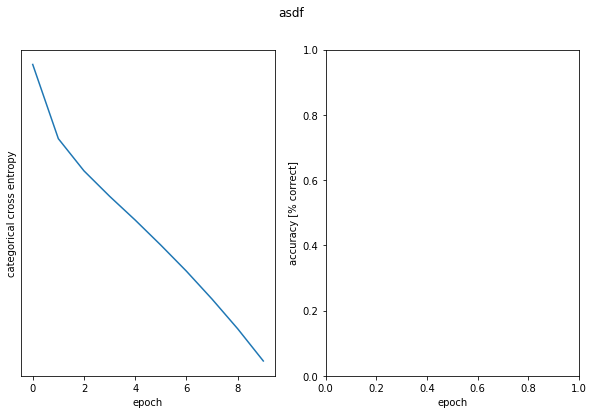

In [32]:
plot_history(history, "asdf")

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) 

B) 

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: 

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: 

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution